<a href="https://colab.research.google.com/github/yuka1369/AttractingContributors-Book/blob/main/unsupervised_lexical_simplification_with_bert_Arangeipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Lexical Simplification with BERT
## Overview
Lexical simplification aims to replace complex words in a given sentence with their simpler alternatives whlie preserve meaning.  This notebook performs lexical simplification with BERT following "*A Simple BERT-Based Approach for Lexical Simplification*" [1]. The proposed method is a very simple, but effective.   



## Settings

In [ ]:
#@title Setup environment
!pip install --quiet pytorch-transformers
!pip install --quiet pytorch-nlp
!pip install --quiet tqdm

     |████████████████████████████████| 176 kB 7.3 MB/s 
     |████████████████████████████████| 132 kB 48.4 MB/s 
     |████████████████████████████████| 1.2 MB 54.3 MB/s 
     |████████████████████████████████| 895 kB 57.5 MB/s 
     |████████████████████████████████| 8.6 MB 18.1 MB/s 
     |████████████████████████████████| 79 kB 2.9 MB/s 
     |████████████████████████████████| 138 kB 39.4 MB/s 
     |████████████████████████████████| 127 kB 48.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 90 kB 286 kB/s 


In [ ]:
#@title Setup common imports
from collections import Counter
from tqdm import tqdm
import numpy as np
import torch
from pytorch_transformers import (
    BertTokenizer,
    BertForMaskedLM,
)

import matplotlib.pyplot as plt
% matplotlib inline

## Substitution Generation
We obtain substitution candidate...
<!-- Figure: The model architechture -->



In [ ]:
# Build model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

100%|██████████| 440473133/440473133 [00:18<00:00, 23965929.29B/s]


In [ ]:
# Model's input
#text = "[CLS] the cat perched on the mat [SEP] the cat perched on the mat [SEP]"

#text = "[CLS] the man researches about NMT [SEP]  the man researches about NMT [SEP]"
#text = "[CLS] BLUE is a well-known evaluation method for translation studies. [SEP]  BLUE is a well-known evaluation method for translation studies. [SEP]"
#text = "[CLS] transformer is a well-known method for translation studies [SEP]  transformer is a well-known method for translation studies [SEP]"
text = "[CLS] the man researches about transform [SEP]  the man researches about transform [SEP]"

masked_idx = 11
#masked_idx = 10


In [ ]:
# Tokenize a text
tokenized_text = tokenizer.tokenize(text)

print(tokenized_text)

# Mask a complex token which should be substituted
complex_word = tokenized_text[masked_idx]
tokenized_text[masked_idx] = '[MASK]'

# Convert inputs to PyTorch tensors
tokens_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
#segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
#segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1]
tokens_tensor = torch.tensor([tokens_ids])
segments_tensors = torch.tensor([segments_ids])

['[CLS]', 'the', 'man', 'researches', 'about', 'transform', '[SEP]', 'the', 'man', 'researches', 'about', 'transform', '[SEP]']


In [ ]:
# Predict a masked token
model.eval()
if torch.cuda.is_available():
    tokens_tensor = tokens_tensor.to('cuda')
    segments_tensors = segments_tensors.to('cuda')
    model.to('cuda')
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

Input: [CLS] the man researches about transform [SEP] the man researches about [MASK] [SEP]
Top10: ['.', ';', '?', '!', '|', '...', ':', 'and', ',', '।', '-', '[UNK]', 'you', '/', '॥', 'it', 'me', 'the', "'", 'that']


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2405 missing from current font.
  font.set_text(s, 0, flags=flags)


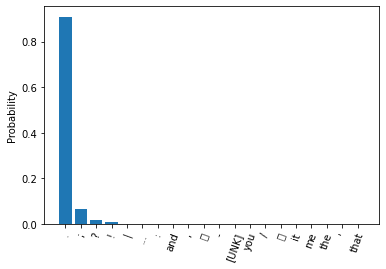

In [ ]:
# Output top 10 of candidates
#topk_score, topk_index = torch.topk(predictions[0, masked_idx], 10)
topk_score, topk_index = torch.topk(predictions[0, masked_idx], 20)
topk_tokens = tokenizer.convert_ids_to_tokens(topk_index.tolist())
print(f'Input: {" ".join(tokenized_text)}')
print(f'Top10: {topk_tokens}')

# Visualize output probabilities
plt.bar(topk_tokens, torch.softmax(topk_score, 0).tolist())
plt.xticks(rotation=70)
plt.ylabel('Probability')
plt.show()

## Substitution Ranking
Previous section, we obtained subsitution candidates of a complex word "*perched*".  
In this section, we rank substitution candidates by following four features:

- Probability of BERT prediction;
- Probability of n-gram language model;
- Similarity obtained by FastText;
- Word frequency;

We choose the top of candidate with the highest average rank over all features as the simplification replacement.

In this notebook, we use only a **probabitity of BERT predicaiton** and a **word frequency** for ranking step.

In [ ]:
#@title Download the Children's Book Test (CBT)
!wget http://www.thespermwhale.com/jaseweston/babi/CBTest.tgz
!tar -xzf ./CBTest.tgz
!DATA_PATH=./CBTest/data; cat ${DATA_PATH}/cbt_train.txt ${DATA_PATH}/cbt_valid.txt ${DATA_PATH}/cbt_test.txt > ./cbt_all.txt
!wc ./cbt_all.txt

--2022-03-15 08:59:04--  http://www.thespermwhale.com/jaseweston/babi/CBTest.tgz
Resolving www.thespermwhale.com (www.thespermwhale.com)... 50.31.160.191
Connecting to www.thespermwhale.com (www.thespermwhale.com)|50.31.160.191|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120547669 (115M) [application/x-tar]
Saving to: ‘CBTest.tgz’

CBTest.tgz          100%[===================>] 114.96M  11.2MB/s    in 11s     

2022-03-15 08:59:15 (10.9 MB/s) - ‘CBTest.tgz’ saved [120547669/120547669]

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCH

In [ ]:
#@title Build a table of word frequency
def count_lines(path):
  with open(path, 'r') as f:
    return sum([1 for _ in f])

word_frequency = Counter()
filepath = './cbt_all.txt'
n_lines = count_lines(filepath)
with open(filepath, 'r') as f:
  for line in tqdm(f, total=n_lines):
    if line.startswith("_BOOK_TITLE_"):
      continue
    else:
      tokens = tokenizer.tokenize(line.rstrip())
      for token in tokens:
        word_frequency[token] += 1

100%|██████████| 292912/292912 [02:17<00:00, 2123.07it/s]


In [ ]:
# substitution ranking
bert_rank = np.array([i for i in range(len(topk_tokens))])
frequency_rank = np.argsort([-word_frequency[token] for token in topk_tokens])
avg_rank = np.argsort((bert_rank + frequency_rank) / 2)

# sort candidates and except a complex word
candidates = [topk_tokens[i] for i in avg_rank if topk_tokens[i] != complex_word]

In [ ]:
tokenized_text[masked_idx] = candidates[0]
print(" ".join(tokenized_text))

[CLS] the man researches about transform [SEP] the man researches about ? [SEP]


## References

[1] [A Simple BERT-Based Approach for Lexical Simplification
](https://arxiv.org/abs/1907.06226)  
[2] [huggingface/transformers](https://github.com/huggingface/transformers)


In [ ]:
›

SyntaxError: ignored